In [1]:
import datetime
import galsim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import time
import webbpsf
from astropy import convolution
from galsim import InterpolatedImage, Image
from galsim import roman
from glob import glob
from hydra import initialize, compose
from matplotlib import colors
from pprint import pprint
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, psf, gs, color

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:49<00:00, 56.44s/it]


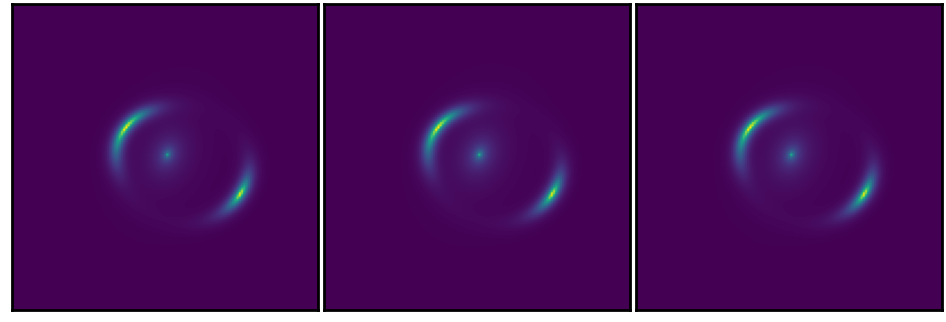

In [2]:
oversample_factor = 3

bands = util.hydra_to_dict(config.pipeline)['band']
exposure_time = util.hydra_to_dict(config.pipeline)['exposure_time']

lens = SampleStrongLens()
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'pyhalo', 'cdm_subhalos_tuple')))

models = []
for band in tqdm(bands):
    model = lens.get_array(num_pix=45 * oversample_factor, side=4.95, band=band)
    models.append(model)

plot.plot_list(models)

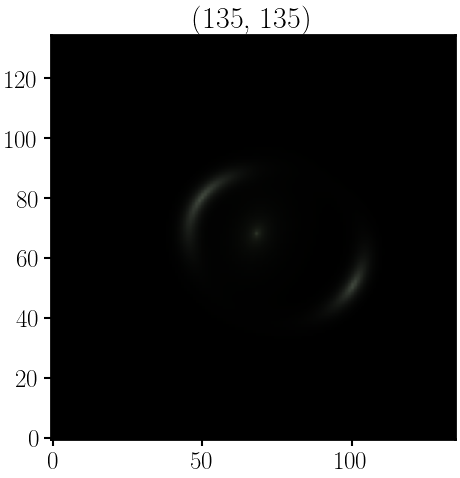

In [3]:
color_model = color.get_rgb(image_b=models[0], image_g=models[1], image_r=models[2])

plot.plot(color_model, title=model.shape)

In [4]:
# import random
# from astropy.coordinates import SkyCoord

# date = datetime.datetime(2027,7,7,0,0,0)
# # date = datetime.datetime(2025,3,20,9,2,0)

# for i in tqdm(range(10000)):
#     ra = random.uniform(15, 45)
#     dec = random.uniform(-45, -15)

#     skycoord = SkyCoord(ra, dec, frame='icrs', unit='deg')
#     ra_hms, dec_dms = skycoord.to_string('hmsdms').split(' ')

#     ra_targ = galsim.Angle.from_hms(ra_hms)
#     dec_targ = galsim.Angle.from_dms(dec_dms)
#     targ_pos = galsim.CelestialCoord(ra=ra_targ, dec=dec_targ)

#     if not galsim.roman.allowedPos(targ_pos, date):
#         print('Not allowed')
#         break

In [5]:
# create galsim rng
rng = galsim.UniformDeviate()

# determine detector and position
detector = gs.get_random_detector()
detector_pos = gs.get_random_detector_pos()

# get wcs
wcs_dict = gs.get_random_hlwas_wcs()

Detector: 15
Detector position: 958, 1382
RA: 33.92912392867072, DEC: -41.12784801301381


In [6]:
print(galsim.roman.jitter_rms)

0.014


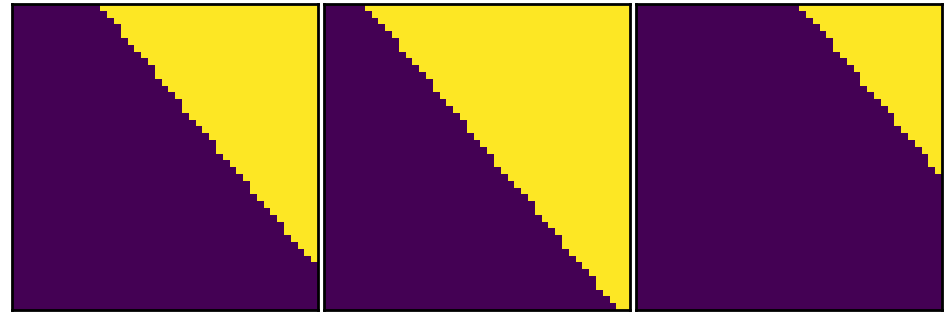

In [7]:
# calculate sky backgrounds for each band
bkgs = gs.get_sky_bkgs(wcs_dict, bands, detector, exposure_time, num_pix=45)

plot.plot_list([i.array for i in bkgs.values()])

In [8]:
images = []

for i, band in enumerate(bands):
    array = models[i]

    # get flux
    total_flux_cps = lens.get_total_flux_cps(band)

    # get interpolated image
    interp = galsim.InterpolatedImage(galsim.Image(array), scale=0.11 / oversample_factor,
                                      flux=total_flux_cps * exposure_time)

    # generate PSF and convolve
    convolved = gs.convolve(interp, band, detector, detector_pos, 45, pupil_bin=1)

    # add sky background to convolved image
    final_image = convolved + bkgs[band]

    # integer number of photons are being detected, so quantize
    final_image.quantize()

    # add all detector effects
    galsim.roman.allDetectorEffects(final_image, prev_exposures=(), rng=rng, exptime=exposure_time)

    # quantize, as the analog-to-digital converter reads in an integer value
    final_image.quantize()

    final_array = final_image.array
    images.append(final_array)

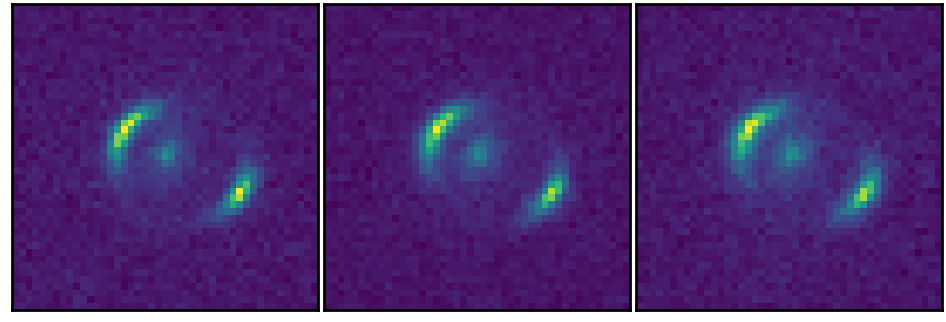

In [9]:
plot.plot_list(images)

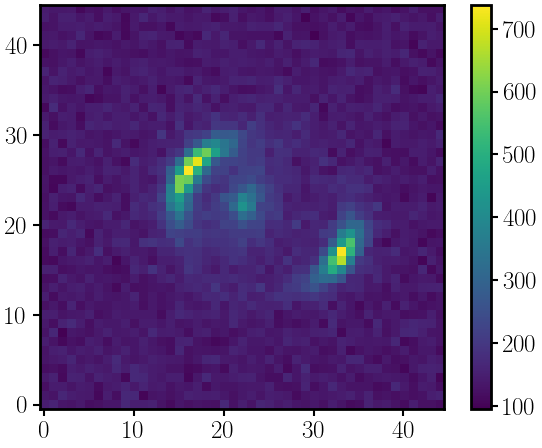

In [10]:
plot.plot(images[0], colorbar=True)

In [11]:
images = [i / exposure_time for i in images]

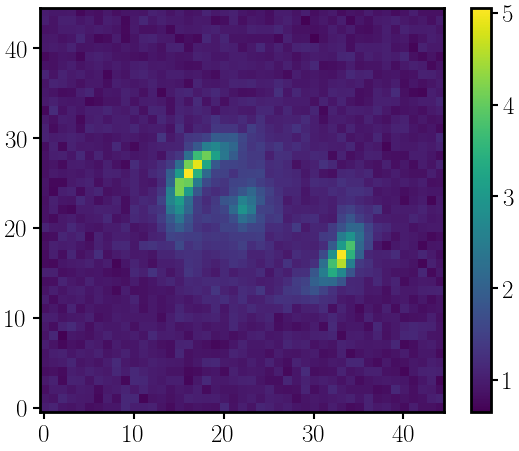

In [12]:
plot.plot(images[0], colorbar=True)

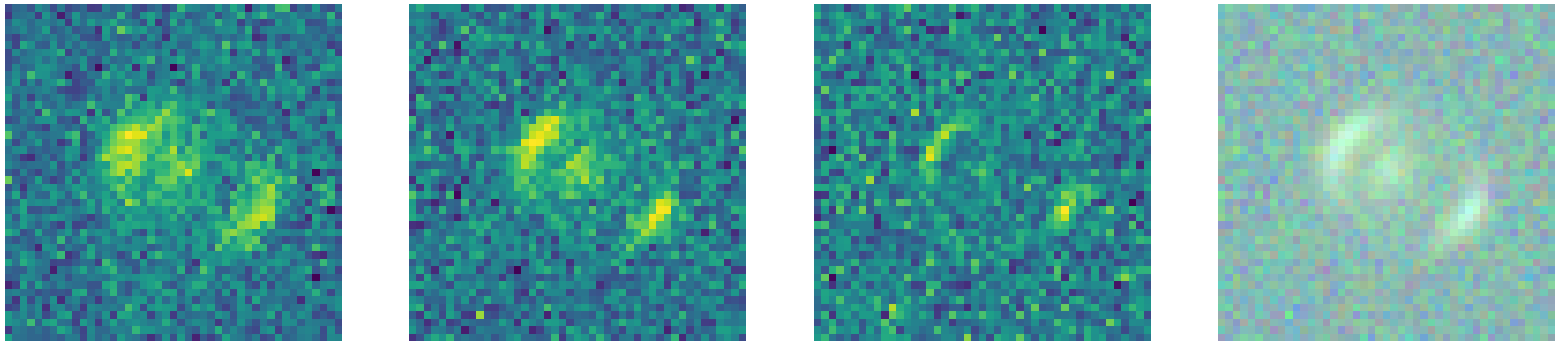

In [13]:
from astropy.visualization import make_lupton_rgb

image_r = images[2]
image_g = images[1]
image_b = images[0]

# rescale to be between 0 and 255 for floats
max = plot_util.get_v([image_b, image_g, image_r])
scale_factor = max / 255
image_b /= scale_factor
image_g /= scale_factor
image_r /= scale_factor

# minimum = np.min(np.concatenate((image_b, image_g, image_r)))
color_image = make_lupton_rgb(image_r=image_r, image_g=image_g, image_b=image_b, minimum=0, stretch=5, Q=8)

f, ax = plt.subplots(1, 4, figsize=(20, 8))
ax[0].imshow(color_image[:, :, 0])
ax[1].imshow(color_image[:, :, 1])
ax[2].imshow(color_image[:, :, 2])
ax[3].imshow(color_image)

for i in ax:
    i.set_axis_off()

plt.show()

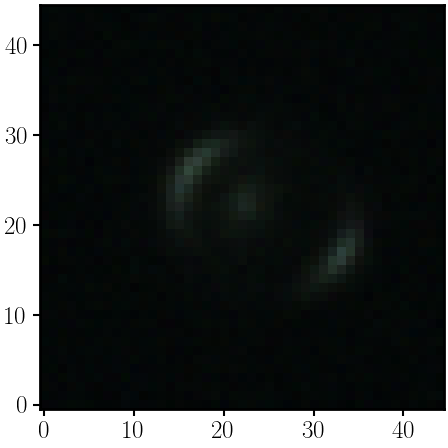

In [14]:
color_image = color.get_rgb(image_b=images[0], image_g=images[1], image_r=images[2])

plt.imshow(color_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


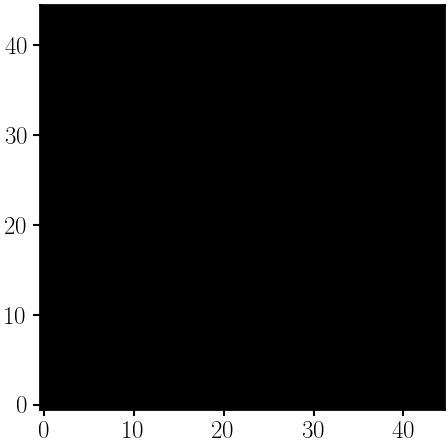

In [15]:
color_image = color.get_rgb_log10(image_b=images[0], image_g=images[1], image_r=images[2])

plt.imshow(color_image)
plt.show()